In [43]:
# data manipulation
import pandas as pd
import sqlite3
import regex as re
from helper_functions import *
import numpy as np

# data visulization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# 1) Research Questsions

1. What are guests searching for in Dublin?
2. Which inquireies hosts tend to accept? 
3. What are the gaps between guest demand and host supply that the new city manager could plug to increase the number of bookings in Dublin? 
4. What other data would be useful to have to deepen the analysis & understanding? 

# 2) Data preperation

Connecting to data via sqlite.

In [15]:
# Connect to an SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('/Users/jpuray/databases/dublin')
# Create a cursor object
cursor = conn.cursor()

In [16]:
contacts = pd.read_sql_query("SELECT * FROM contacts", conn)
searches = pd.read_sql_query("SELECT * FROM searches", conn)

## Converting Datatypes

Currently all the data are of type 'object'. We need to convert them to their appropriate data types.

In [17]:
print(contacts.dtypes)
print(searches.dtypes)

id_guest          object
id_host           object
id_listing        object
ts_contact_at     object
ts_reply_at       object
ts_accepted_at    object
ts_booking_at     object
ds_checkin        object
ds_checkout       object
n_guests          object
n_messages        object
dtype: object
ds                      object
id_user                 object
ds_checkin              object
ds_checkout             object
n_searches              object
n_nights                object
n_guests_min            object
n_guests_max            object
origin_country          object
filter_price_min        object
filter_price_max        object
filter_room_types       object
filter_neighborhoods    object
dtype: object


In [18]:
# Converting to datetime
contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'], errors='coerce')
contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'], errors='coerce')
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'], errors='coerce')
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'], errors='coerce')
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'],errors='coerce')
contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'], errors='coerce')
contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'], errors='coerce')
# Converting to numeric
contacts['n_guests'] = pd.to_numeric(contacts['n_guests'],errors='coerce')
contacts['n_messages'] = pd.to_numeric(contacts['n_messages'],errors='coerce')

In [19]:
# Converting to datetime
searches['ds'] = pd.to_datetime(searches['ds'], errors='coerce')
searches['ds_checkin'] = pd.to_datetime(searches['ds_checkin'], errors='coerce')
searches['ds_checkout'] = pd.to_datetime(searches['ds_checkout'], errors='coerce')

# Converting to int
searches['n_searches'] = pd.to_numeric(searches['n_searches'],errors='coerce')
searches['n_nights'] = pd.to_numeric(searches['n_nights'],errors='coerce')
searches['n_guests_min'] = pd.to_numeric(searches['n_guests_min'],errors='coerce')
searches['n_guests_max'] = pd.to_numeric(searches['n_guests_max'],errors='coerce')
searches['filter_price_min'] = pd.to_numeric(searches['filter_price_min'],errors='coerce')
searches['filter_price_max'] = pd.to_numeric(searches['filter_price_max'],errors='coerce')
searches['n_guests_max'] = pd.to_numeric(searches['n_guests_max'],errors='coerce')

The columns `filter_room_types` and `filter_neighborhoods` are lists so we need to create a custom function to convert these values.

In [20]:
print(searches['filter_room_types'].value_counts())
print(searches['filter_neighborhoods'].value_counts())

filter_room_types
                                                                                                                  19546
,Entire home/apt                                                                                                   6331
Entire home/apt                                                                                                    3667
,Private room                                                                                                      1693
Private room                                                                                                       1147
                                                                                                                  ...  
,Entire home/apt,Private room,Shared room,Private room,Shared room,Entire home/apt,Shared room,Entire home/apt        1
,Entire home/apt,Entire home/apt,Private room,Private room,Shared room,Entire home/apt                                1
Entire home/apt,Shared

In [21]:
def string_to_list(string):
    li = re.split(r',', string)
    li = set(li) # remove duplicates
    out_li = [word for word in li if word != '']
    return out_li

In [22]:
searches['filter_room_types'] = searches['filter_room_types'].apply(string_to_list)
searches['filter_neighborhoods'] = searches['filter_neighborhoods'].apply(string_to_list)

In [23]:
print(searches['filter_neighborhoods'].value_counts())

filter_neighborhoods
[]                                                                                                                                                        34391
[City Centre]                                                                                                                                               752
[City Centre, Old City]                                                                                                                                      66
[Temple Bar]                                                                                                                                                 48
[City Centre, Temple Bar]                                                                                                                                    45
                                                                                                                                                          ...  
[Grafton Street/St.

We have finished preparing and converting all the data to the appropriate data types. Which we can see below.

In [24]:
print(contacts.dtypes)
print(searches.dtypes)

id_guest                  object
id_host                   object
id_listing                object
ts_contact_at     datetime64[ns]
ts_reply_at       datetime64[ns]
ts_accepted_at    datetime64[ns]
ts_booking_at     datetime64[ns]
ds_checkin        datetime64[ns]
ds_checkout       datetime64[ns]
n_guests                   int64
n_messages                 int64
dtype: object
ds                      datetime64[ns]
id_user                         object
ds_checkin              datetime64[ns]
ds_checkout             datetime64[ns]
n_searches                       int64
n_nights                       float64
n_guests_min                     int64
n_guests_max                     int64
origin_country                  object
filter_price_min               float64
filter_price_max               float64
filter_room_types               object
filter_neighborhoods            object
dtype: object


## Feature Engineering

### Searches 

In `searches` we will create a new feature that gives us what day of the week guests are searching to check in and the average number of guests they intend to get the Airbnb for.

In [25]:
searches['checkin_day'] = searches['ds_checkin'].dt.day_name() # creating a column with the day of the week
searches['avg_guests'] = (searches['n_guests_max'] + searches['n_guests_min']) / 2 

### Contacts

In `contacts` we can calculate the length of the day by subtracting the check in and check out date, as well as the day of the week guests are looking to checkin.

In [41]:
# Length of stay by days
contacts['stay_length'] = (contacts['ds_checkout'] - contacts['ds_checkin']).dt.days.astype(int)
contacts['checkin_day'] = contacts['ds_checkin'].dt.day_name()

# 3) EDA

## Exploring Searches Data

Main question: **What are guests searching for in Dublin?**

Subquestions:
 - a) How many nights do guests plan to stay? 
 - b) How many guests do customers plan to stay with? 
 - c) What are the most popular days to checkin? 
 - d) What room and neighborhood types are most in demand? 

In [27]:
print(searches.shape)
print(searches.ds.min())
print(searches.ds.max())

(35737, 15)
2014-10-01 00:00:00
2014-10-14 00:00:00


The searches dataset ranges 2 weeks, from 10/1/2014 to 10/14/2014, and consists of 35,737 rows of data.

In [28]:
searches.describe()

,ds,ds_checkin,ds_checkout,n_searches,n_nights,n_guests_min,n_guests_max,filter_price_min,filter_price_max,avg_guests
count,35737,23888,23888,35737.000000,23888.000000,35737.000000,35737.000000,13322.000000,1.332200e+04,35737.000000
mean,2014-10-07 14:32:34.478551552,2014-11-27 22:42:10.609511168,2014-12-05 14:50:57.468184832,9.206565,7.672765,1.742955,2.105857,8.470200,9.019063e+07,1.924406
min,2014-10-01 00:00:00,2014-10-01 00:00:00,2014-10-02 00:00:00,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000e+00,1.000000
25%,2014-10-04 00:00:00,2014-10-17 00:00:00,2014-10-23 00:00:00,1.000000,2.000000,1.000000,1.000000,0.000000,8.600000e+01,1.000000
50%,2014-10-08 00:00:00,2014-11-03 00:00:00,2014-11-09 00:00:00,4.000000,3.000000,1.000000,2.000000,0.000000,1.390000e+02,1.500000
75%,2014-10-11 00:00:00,2014-12-13 00:00:00,2014-12-24 00:00:00,10.000000,5.000000,2.000000,2.000000,0.000000,3.010000e+02,2.000000
max,2014-10-14 00:00:00,2016-06-02 00:00:00,2016-08-17 00:00:00,448.000000,399.000000,16.000000,16.000000,1250.000000,1.073742e+09,16.000000
std,NaN,NaN,NaN,17.348746,21.557614,1.460440,1.817358,53.987679,2.978482e+08,1.535127


This function was created to help visualize the distributions. Removing the outliers helps visualize the data better when plotting a histogram, but they are not removed completely from our analysis.

In [29]:
def remove_outliers(data):
    # Calculate quartiles
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove outliers
    data_no_outliers = [x for x in data if x >= lower_bound and x <= upper_bound]
    return data_no_outliers

### a) How many nights do guests plan to stay? 

Text(0.5, 1.0, 'Distribution of n nights in Searches')

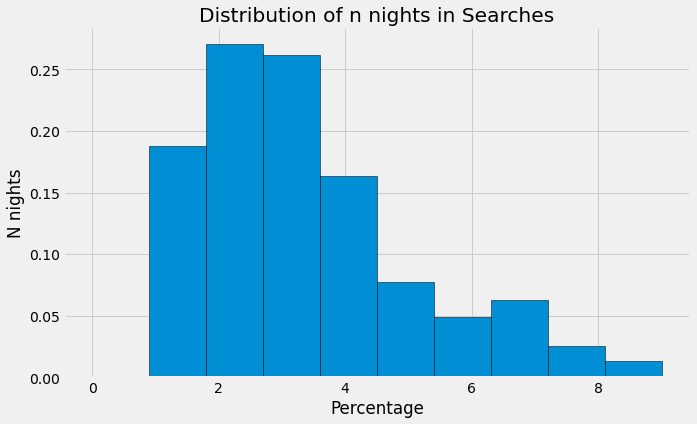

In [44]:
# Plot histogram
n_nights_no_outliers = remove_outliers(searches['n_nights'])
plt.figure(figsize=(10,6))
plt.hist(n_nights_no_outliers,bins=10, edgecolor='black',density=True)

plt.xlabel('Percentage')
plt.ylabel('N nights')
plt.title('Distribution of n nights in Searches')

In [31]:
((searches['n_nights'].value_counts() / len(searches)).sort_values(ascending=False))[:5]

/var/folders/_n/2lzdwcvx2n9087rmk11qlfdw0000gn/T/ipykernel_21683/5914475.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  ((searches['n_nights'].value_counts() / len(searches)).sort_values(ascending=False))[:5]


n_nights
2.0    0.143297
3.0    0.138428
1.0    0.099477
4.0    0.086493
5.0    0.040994
Name: count, dtype: float64

Guests plan to stay on average from 2 to 3 days on average, up to 8 days. 

### b) How many guests do customers plan to stay with? 

Text(0.5, 1.0, 'Distribution of average number of guests in Searches')

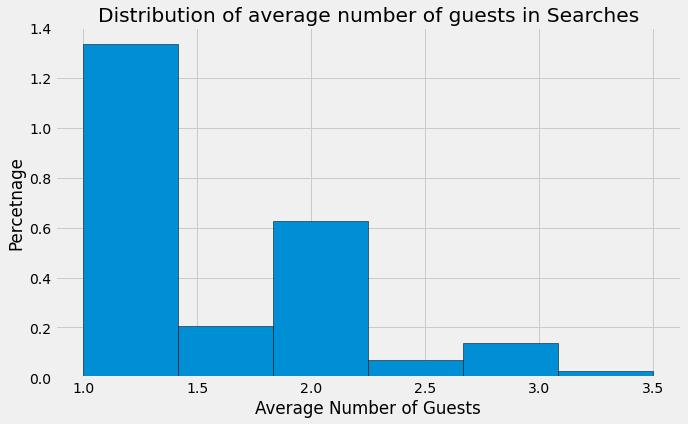

In [45]:
n_guests_avg_no_outliers = remove_outliers(searches['avg_guests'])
plt.figure(figsize=(10,6))
plt.hist(n_guests_avg_no_outliers, bins=6,edgecolor='black',density=True)

plt.xlabel('Average Number of Guests')
plt.ylabel('Percetnage')
plt.title('Distribution of average number of guests in Searches')

In [33]:
((searches['avg_guests'].value_counts() / len(searches)).sort_values(ascending=False))[:5]

/var/folders/_n/2lzdwcvx2n9087rmk11qlfdw0000gn/T/ipykernel_21683/984291373.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  ((searches['avg_guests'].value_counts() / len(searches)).sort_values(ascending=False))[:5]


avg_guests
1.0    0.494446
2.0    0.231889
1.5    0.076755
3.0    0.051347
4.0    0.050816
2.5    0.025044
5.0    0.017349
Name: count, dtype: float64

A vast majority of guests plan to to have 1 (roughly 49%) or 2 (roughly 23%) guests in their Airbnb.

### c) What are the most popular days to checkin?

Text(0.5, 1.0, 'Most Popular Checkin Days')

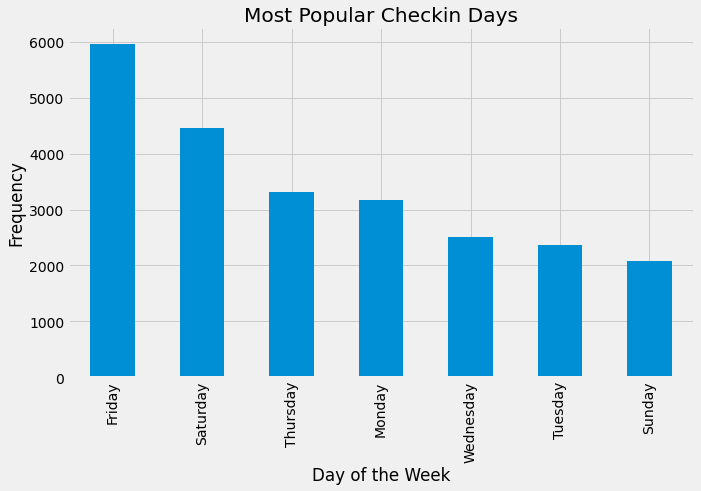

In [46]:
searches[['ds','checkin_day']].groupby('checkin_day').count().sort_values(by='ds',ascending=False).plot(kind='bar',legend=None,figsize=(10,6))
# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Most Popular Checkin Days')

Most popular days guests are searching to check in are Friday and Saturday.

### d) What room and neighborhood types are most in demand? 

In [47]:
from collections import Counter

room_type_counts = Counter()
neighborhood_type_counts = Counter()

for _,row in searches.iterrows():
    room_types = row['filter_room_types']
    neighborhood_types = row['filter_neighborhoods']
    for room in room_types:
        room_type_counts[room] += 1
    for neighborhood in neighborhood_types:
        neighborhood_type_counts[neighborhood] += 1

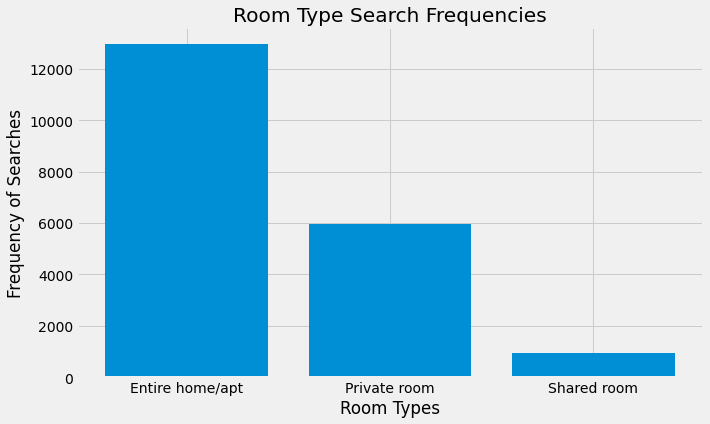

In [48]:
# Extract keys and values from the Counter object
room_keys = list(room_type_counts.keys())
room_values = list(room_type_counts.values())

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(room_keys, room_values)

# Add labels and title
plt.xlabel('Room Types')
plt.ylabel('Frequency of Searches')
plt.title('Room Type Search Frequencies')

# Show the plot
plt.show()

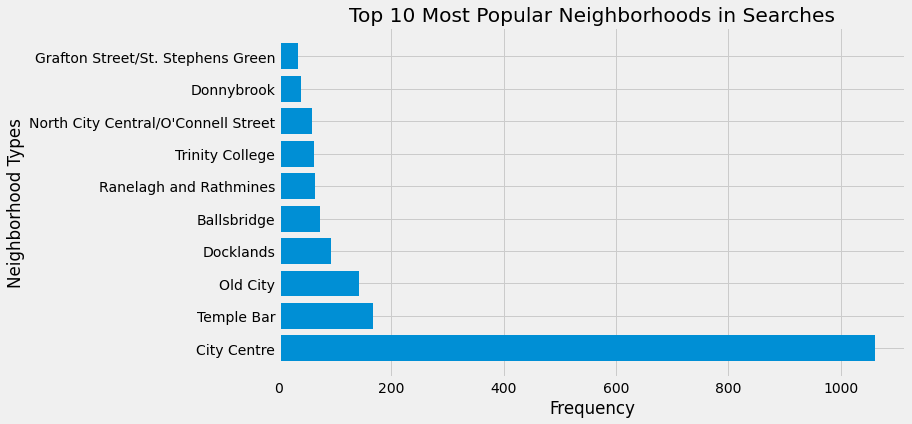

In [49]:
# Sort the keys and values based on counts
sorted_counts = sorted(neighborhood_type_counts.items(), key=lambda x: x[1], reverse=True)
# Select the top 10 items
top_10 = sorted_counts[:10]

# Extract keys and values for the top 10 items
neighborhood_keys = [item[0] for item in top_10]
neighborhood_values = [item[1] for item in top_10]

# Plot the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(neighborhood_keys, neighborhood_values)

# Add labels and title
plt.xlabel('Frequency')
plt.ylabel('Neighborhood Types')
plt.title('Top 10 Most Popular Neighborhoods in Searches')

# Show the plot
plt.show()

Summary: Based on the data the most common things guests are searching for "Entire home/apt" type rooms and places that are in the neighborhood of City Centre. Furthermore, many guests are searching for check-in dates that are closer to the weekend such as Friday and Saturday, and on average looking to spend 3 nights. 

## Exploring Contacts Records

Main Question: **What inquiries do host tend to accept?**

Subquestions:
1. What checkin days are usually accepted? 
2. What is average number of nights spent for an accepted booking? 
3. What is the average number of guests in booking that is accepted? 

Initially, we will filter the dataset by accepted records. By utilizing the `ts_accepted_at field`, which denotes the UTC timestamp when the host accepts the inquiry, we can isolate accepted inquiries by removing rows where the values are `NaT`, indicating that the host never accepted the inquiry. This filtering process is essential because accepted inquiries provide a more accurate representation of the available Airbnbs in the market. If an inquiry is rejected, it could indicate a discrepancy between demand and supply.

In [50]:
accepted = contacts[~contacts['ts_accepted_at'].isna()]

### 1) What checkin days are usually accepted? 

Text(0.5, 1.0, 'Most Popular Checkin Days')

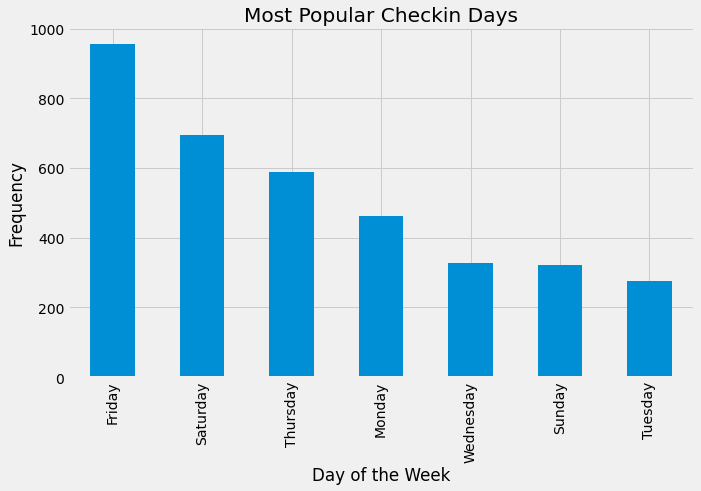

In [51]:
accepted[['id_guest','checkin_day']].groupby('checkin_day').count().sort_values(by='id_guest',ascending=False).plot(kind='bar',legend=None,figsize=(10,6))
# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Most Popular Checkin Days')

The most common days that checkin days that are accepted by hosts are Friday and Saturday, similar to our findings in searches.

### 2) What is average number of nights spent for an accepted booking? 

Text(0.5, 1.0, 'Distribution of length of stay in days')

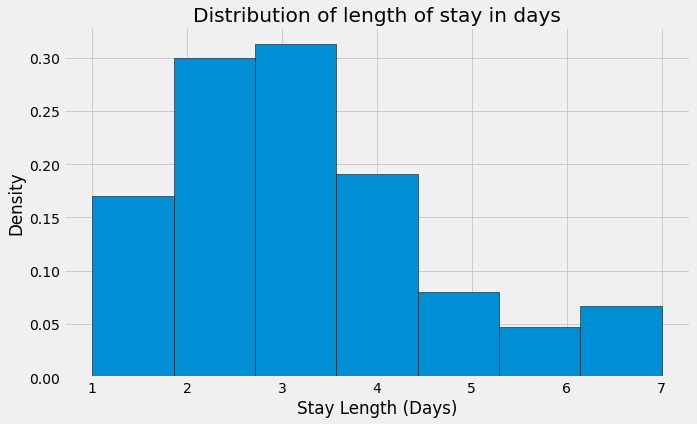

In [52]:
stay_length_no_outliers = remove_outliers(accepted['stay_length'])
plt.figure(figsize=(10,6))
plt.hist(stay_length_no_outliers, bins=7,edgecolor='black',density=True)

plt.xlabel('Stay Length (Days)')
plt.ylabel('Density')
plt.title('Distribution of length of stay in days')

The length of accepted stays generally range from 1 to 4 days on average.

### 3) What is the average number of guests in booking that is accepted? 

Text(0.5, 1.0, 'Distribution of length of stay in days')

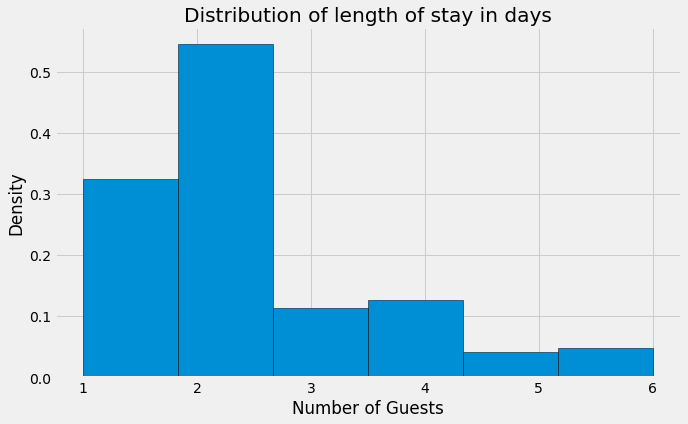

In [53]:
plt.figure(figsize=(10,6))
n_guests_no_outliers = remove_outliers(accepted['n_guests'])
plt.hist(n_guests_no_outliers,bins=6,edgecolor='black',density=True)

plt.xlabel('Number of Guests')
plt.ylabel('Density')
plt.title('Distribution of length of stay in days')

In [54]:
pd.Series(n_guests_no_outliers).value_counts() / len(n_guests_no_outliers)

2    0.454112
1    0.270839
4    0.105810
3    0.094864
6    0.039293
5    0.035083
Name: count, dtype: float64

The most common amount of guests in a booking are 2 guests (roughly 55%) and 1 guest (roughly 32%). 

# 4) Results

**What are the gaps between guest demand and host supply that the new city manager could plug to increase the number of bookings in Dublin?**

There appears to be a significant disparity between the demand for Airbnbs and the actual availability in the market. Approximately 56% of searches are specifically seeking Airbnbs for one guest, whereas only 27% of accepted inquiries accommodate a single guest.

In [55]:
accepted_guest_distribution = pd.Series(n_guests_no_outliers).value_counts() / len(n_guests_no_outliers)
accepted_guest_distribution

2    0.454112
1    0.270839
4    0.105810
3    0.094864
6    0.039293
5    0.035083
Name: count, dtype: float64

In [259]:
searches_guests_distribution = pd.Series(n_guests_avg_no_outliers).value_counts() / len(n_guests_avg_no_outliers)
searches_guests_distribution

1.0    0.556606
2.0    0.261041
1.5    0.086405
3.0    0.057803
2.5    0.028193
3.5    0.009954
Name: count, dtype: float64

Given the disrepecny in the supply and demand of Airbnbs in Dublin for 1 guest. The new city manager can increase the number of Airbnbs in Dublin that house 1 guest to meet the demands of the market.

**What other data would be useful to have to deepen the analysis & understanding?**

Including a dataset comprising listings alongside their descriptions and features would significantly enhance our analysis. Within searches, customers can apply various filters like room type, neighborhood type, and price. However, without access to the listings, we cannot assess whether the available rooms meet the demand indicated by these searches.